In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

# Procedure

## 1) Data Inspection and Cleaning
## 2) Train different models, k-NN, Random Forest and LSTM
## 3) Make a multi layer perceptron as a second unit on top of the different models predict sales per shop

## Load Data

In [2]:
sales = pd.read_csv('dataset/sales_train.csv', parse_dates=['date'], 
              dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                  'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'}
                   )
test = pd.read_csv('dataset/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
submission = pd.read_csv('dataset/sample_submission.csv')
items = pd.read_csv('dataset/items.csv',
                         dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
item_categories = pd.read_csv('dataset/item_categories.csv',
                        dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
shops = pd.read_csv('dataset/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})

In [9]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1
1,2013-03-01,0,25,2552,899.00,1
2,2013-05-01,0,25,2552,899.00,-1
3,2013-06-01,0,25,2554,1709.05,1
4,2013-01-15,0,25,2555,1099.00,1


In [6]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [8]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [3]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [4]:
print('Train rows: ', train.shape[0])
print('Train columns: ', train.shape[1])

Train rows:  2935849
Train columns:  10


## All datasets in the same DF

In [5]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-03-01,0,25,2552,899.00,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-05-01,0,25,2552,899.00,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-06-01,0,25,2554,1709.05,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


In [10]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.62,1.24,40.00
std,9.42,16.23,6324.30,1726.44,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


In [11]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


In [22]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
#shops in test_set
leak_train = train[train['shop_id'].isin(test_shop_ids)]
#items in test set 
leak_train = lk_train[lk_train['item_id'].isin(test_item_ids)]

In [23]:
print('Data set size before leaking:', train.shape[0])
print('Data set size after leaking:', leak_train.shape[0])

Data set size before leaking: 2935848
Data set size after leaking: 1224439


In [24]:
train = train.query('item_price > 0')

In [25]:
trainMonthly = lk_train[['date','date_block_num','shop_id','item_category_id','item_id',
                         'item_price','item_cnt_day']]

In [26]:
trainMonthly = trainMonthly.sort_values('date').groupby(['date_block_num','shop_id',
                                                           'item_category_id','item_id'],
                                                          as_index = False)
trainMonthly = trainMonthly.agg({'item_price':['sum','mean'],'item_cnt_day':['sum','mean',
                                                                               'count']})
trainMonthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price',
                         'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [27]:
trainMonthly.head()

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,2,5572,10730.00,1532.86,9,1.29,7
1,0,2,2,5643,4775.21,2387.60,0,0.00,2
2,0,2,5,5583,1188.30,594.15,2,1.00,2
3,0,2,6,7893,5970.00,1990.00,3,1.00,3
4,0,2,6,7894,1490.00,1490.00,1,1.00,1


In [18]:
trainMonthly.head()

,date,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,37,22154,999.00,1
10,2013-03-01,0,25,55,2574,399.00,2
11,2013-05-01,0,25,55,2574,399.00,1
12,2013-07-01,0,25,55,2574,399.00,1
13,2013-08-01,0,25,55,2574,399.00,2


In [28]:
# replacing empty data

shop_ids = trainMonthly['shop_id'].unique()
item_ids = trainMonthly['item_id'].unique()

emptyDF = []

for i in range(34): #date block num
    for shop in shop_ids:
        for item in item_ids:
            emptyDF.append([i,shop,item])
            
emptyDF = pd.DataFrame(emptyDF, columns=['date_block_num','shop_id','item_id'])


In [29]:
trainMonthly = pd.merge(emptyDF,trainMonthly, on=['date_block_num','shop_id','item_id'],
                        how='left')
trainMonthly.fillna(0, inplace=True)

In [30]:
trainMonthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00


In [32]:
# time based features
trainMonthly['year'] = trainMonthly['date_block_num'].apply(lambda 
                                                            x: ((x//12)+2013))
trainMonthly['month'] = trainMonthly['date_block_num'].apply(lambda
                                                           x: (x%12))

In [33]:
# group item_cnt relationship
gp_month_mean = trainMonthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = trainMonthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = trainMonthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = trainMonthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = trainMonthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = trainMonthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

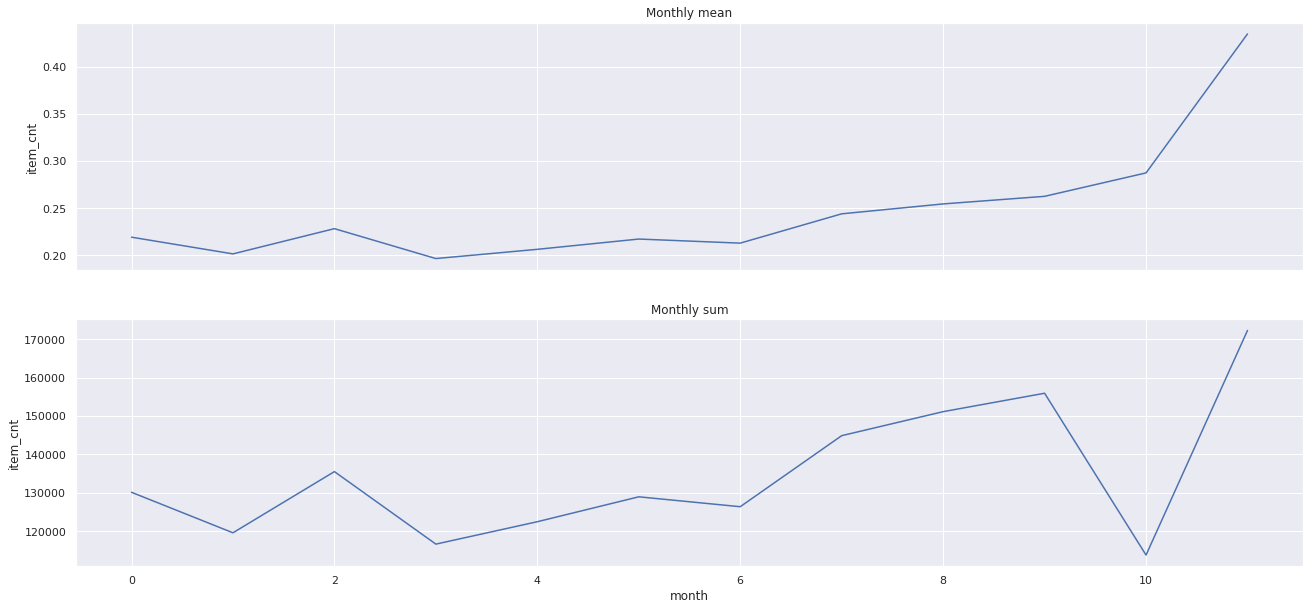

In [34]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, 
             ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, 
             ax=axes[1]).set_title("Monthly sum")
plt.show()

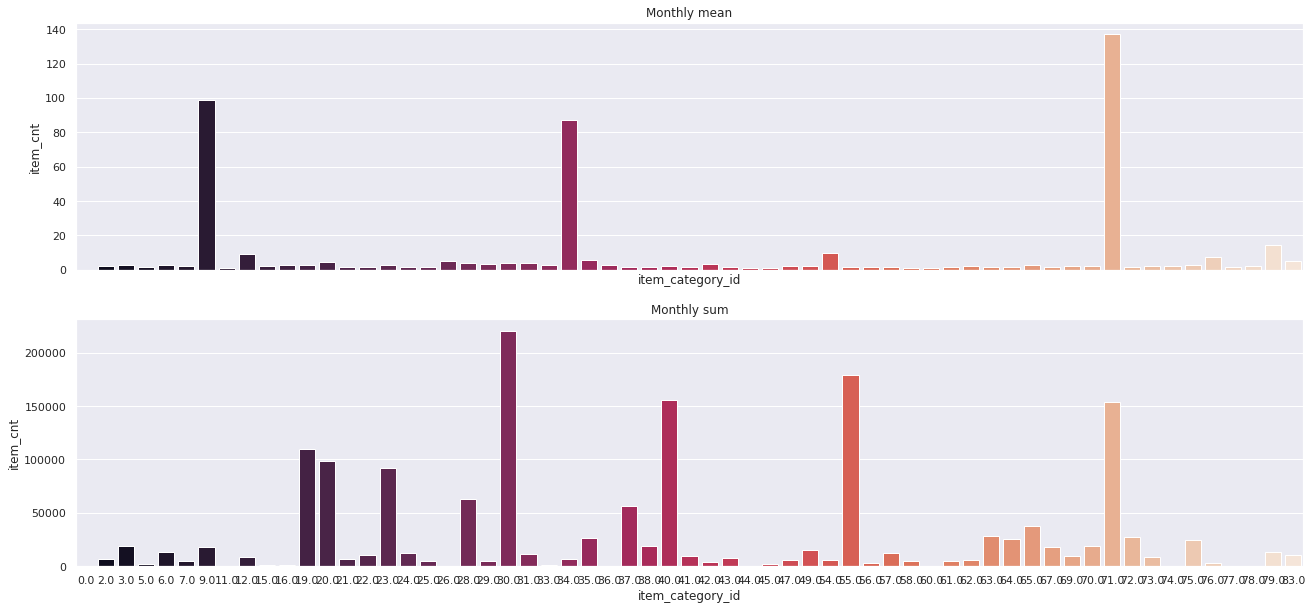

In [35]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

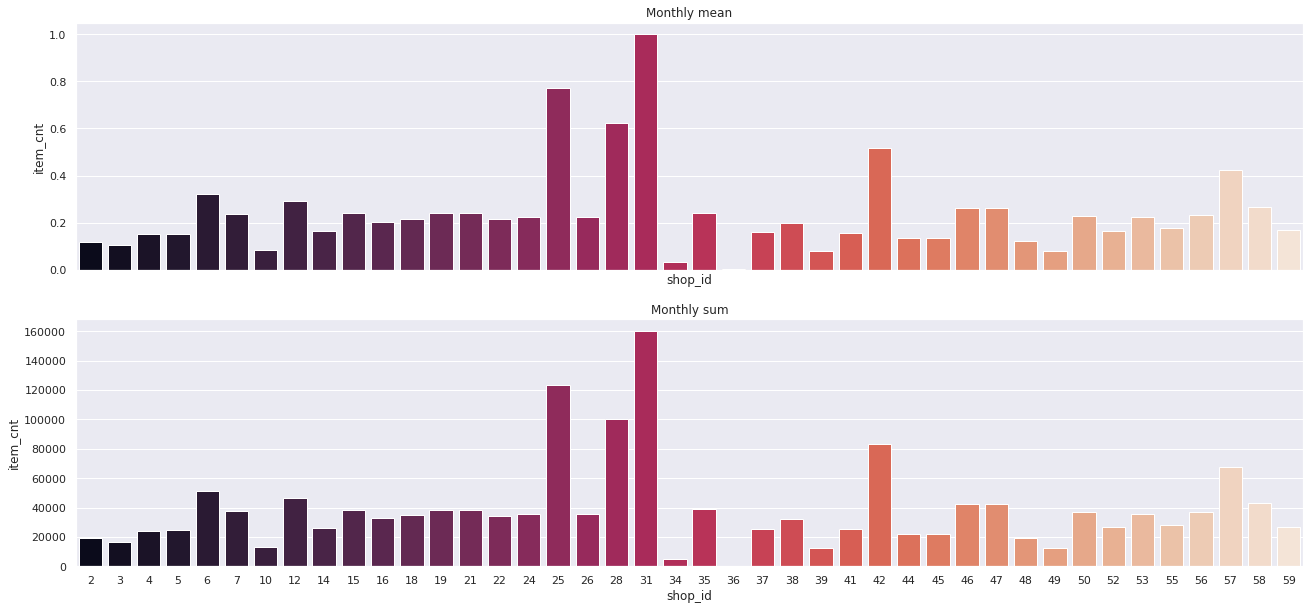

In [36]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

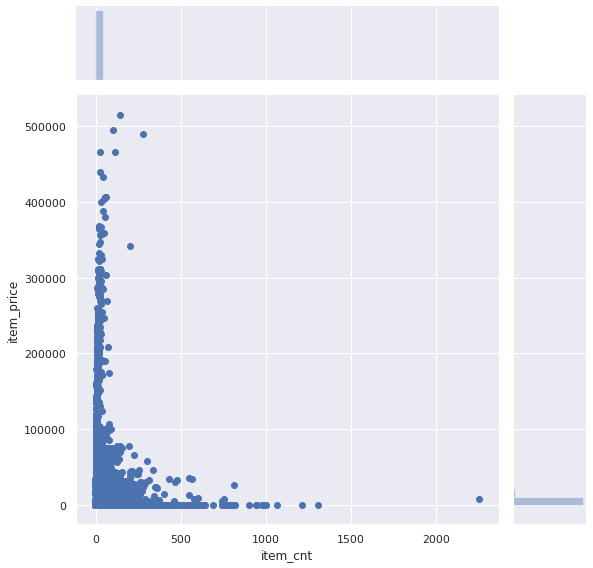

In [37]:
sns.jointplot(x="item_cnt", y="item_price", data=train_monthly, height=8)
plt.show()

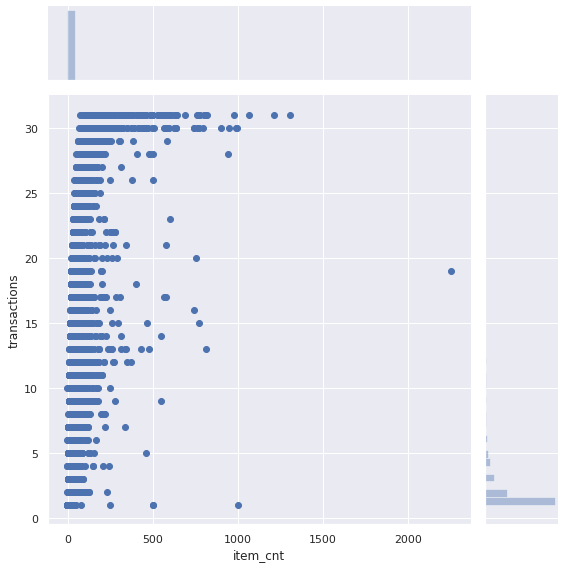

In [38]:
sns.jointplot(x="item_cnt", y="transactions", data=train_monthly, height=8)
plt.show()

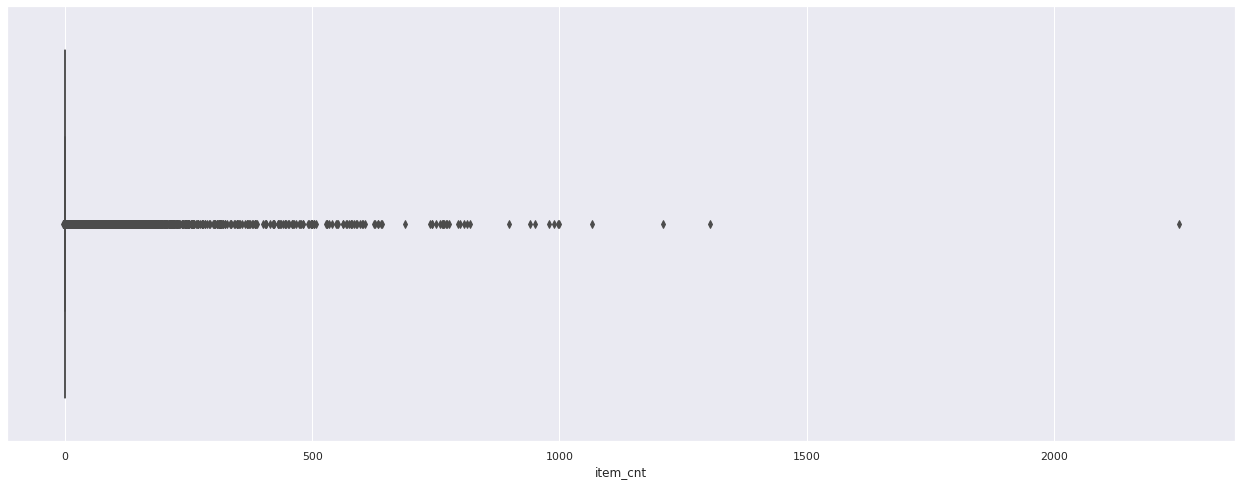

In [42]:
plt.subplots(figsize=(22, 8))
sns.boxplot(trainMonthly['item_cnt'])
plt.show()

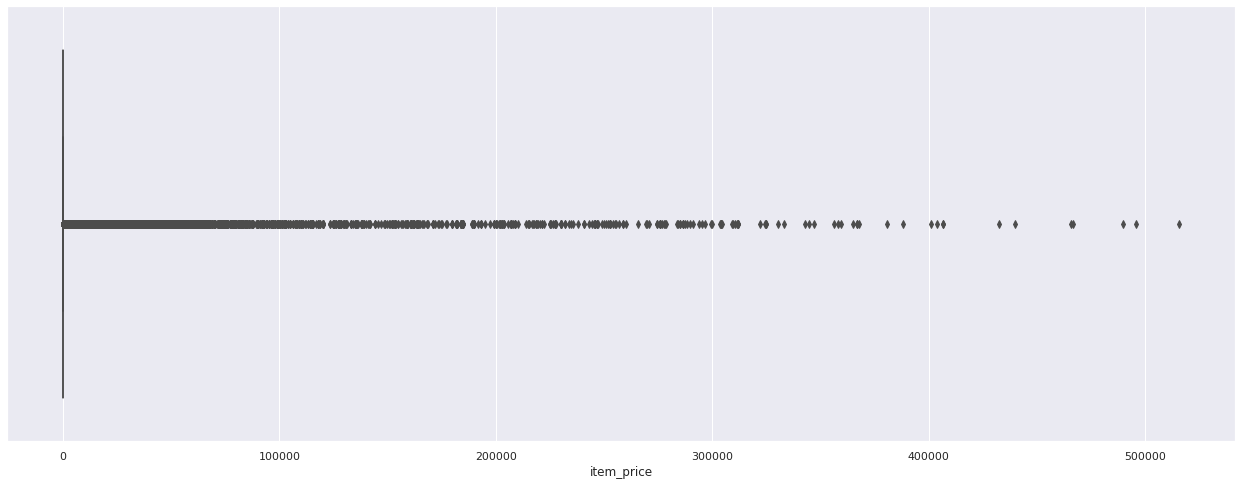

In [41]:
plt.subplots(figsize=(22, 8))
sns.boxplot(trainMonthly['item_price'])
plt.show()

In [43]:
trainMonthly = trainMonthly.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 400000')


In [45]:
trainMonthly['item_cnt_month'] = trainMonthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

In [46]:
trainMonthly['item_price_unit'] = trainMonthly['item_price'] // trainMonthly['item_cnt']
trainMonthly['item_price_unit'].fillna(0, inplace=True)

In [47]:
gp_item_price = trainMonthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

trainMonthly = pd.merge(trainMonthly, gp_item_price, on='item_id', how='left')

In [48]:
trainMonthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month,item_price_unit,hist_min_item_price,hist_max_item_price
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,0,1.00,1192.00,0.00,18979.50
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,0,0.00,inf,0.00,35260.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0,1.00,594.00,0.00,5592.00
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,0,2.00,1990.00,0.00,27950.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,0,2.00,1490.00,0.00,25880.00


## How much price change?

In [50]:
trainMonthly['price_increase'] = trainMonthly['item_price'] - trainMonthly['hist_min_item_price']
trainMonthly['price_decrease'] = trainMonthly['hist_max_item_price'] - trainMonthly['item_price']

## Rolling Window , window size 3 months

In [52]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    trainMonthly[('item_cnt_%s' % function_name[i])] = trainMonthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

# Fill the empty std features with 0
trainMonthly['item_cnt_std'].fillna(0, inplace=True)

## Lag Based Features

In [54]:
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    trainMonthly[ft_name] = trainMonthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    trainMonthly[ft_name].fillna(0, inplace=True)

## Sales Count Trend

In [55]:
trainMonthly['item_trend'] = trainMonthly['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    trainMonthly['item_trend'] -= trainMonthly[ft_name]

trainMonthly['item_trend'] /= len(lag_list) + 1

In [56]:
trainMonthly.head().T

,0,1,2,3,4
date_block_num,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00
item_id,5572.00,5643.00,5583.00,7893.00,7894.00
item_category_id,2.00,2.00,5.00,6.00,6.00
item_price,10730.00,4775.21,1188.30,5970.00,1490.00
mean_item_price,1532.86,2387.60,594.15,1990.00,1490.00
item_cnt,9.00,0.00,2.00,3.00,1.00
mean_item_cnt,1.29,0.00,1.00,1.00,1.00
transactions,7.00,2.00,2.00,3.00,1.00
year,2013.00,2013.00,2013.00,2013.00,2013.00


In [57]:
trainMonthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6728118.00,16.50,9.81,0.00,8.00,16.00,25.00,33.00
shop_id,6728118.00,31.64,17.56,2.00,16.00,35.00,47.00,59.00
item_id,6728118.00,11042.87,6209.70,30.00,5386.00,11266.00,16068.00,22167.00
item_category_id,6728118.00,3.75,13.16,0.00,0.00,0.00,0.00,83.00
item_price,6728118.00,169.77,1792.01,0.00,0.00,0.00,0.00,366860.00
mean_item_price,6728118.00,79.71,522.27,0.00,0.00,0.00,0.00,42990.00
item_cnt,6728118.00,0.19,0.91,0.00,0.00,0.00,0.00,20.00
mean_item_cnt,6728118.00,0.09,0.31,0.00,0.00,0.00,0.00,20.00
transactions,6728118.00,0.17,0.74,0.00,0.00,0.00,0.00,19.00
year,6728118.00,2013.94,0.80,2013.00,2013.00,2014.00,2015.00,2015.00


## Train/Validation Split

In [58]:
train_set = trainMonthly.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = trainMonthly.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = trainMonthly.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/trainMonthly.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/trainMonthly.shape[0])*100)))

Train set records: 4946785
Validation set records: 989412
Test set records: 197879
Train set records: 4946785 (74% of complete data)
Validation set records: 989412 (15% of complete data)


## Find relations with the sales, i.e. shop location, item type, year,month

In [68]:
# Shop mean encoding.
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
# Item mean encoding.
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# Shop with item mean encoding.
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
# Year mean encoding.
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

# Add mean encoding features to train set.
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
# Add mean encoding features to validation set.
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')


In [69]:
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [70]:
# Integer features 
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

In [71]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

## Drop null values

In [72]:
sets = [X_train, X_validation, X_test]
            
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            

X_test.fillna(X_test.mean(), inplace=True)

In [73]:
# Dropping "item_category_id", we don't have it on test set and would be a little hard to create categories for items that exist only on test set.
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

In [74]:
X_test.head().T

,0,1,2,3,4
shop_id,5.00,5.00,5.00,5.00,5.00
item_id,5037.00,5320.00,5233.00,5232.00,5268.00
item_price,749.50,0.00,2997.00,0.00,0.00
mean_item_price,749.50,0.00,999.00,0.00,0.00
item_cnt,1.00,0.00,3.00,0.00,0.00
mean_item_cnt,1.00,0.00,1.00,0.00,0.00
transactions,1.00,0.00,3.00,0.00,0.00
year,2015.00,2015.00,2015.00,2015.00,2015.00
month,9.00,9.00,9.00,9.00,9.00
item_price_unit,749.00,0.00,999.00,0.00,0.00


In [75]:
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
shop_id,214200.00,31.64,17.56,2.00,16.00,34.50,47.00,59.00
item_id,214200.00,11019.40,6252.64,30.00,5381.50,11203.00,16071.50,22167.00
item_price,214200.00,239.98,1854.07,0.00,0.00,0.00,0.00,166944.50
mean_item_price,214200.00,133.82,865.39,0.00,0.00,0.00,0.00,32990.00
item_cnt,214200.00,0.23,0.95,0.00,0.00,0.00,0.00,20.00
mean_item_cnt,214200.00,0.13,0.37,0.00,0.00,0.00,0.00,10.00
transactions,214200.00,0.20,0.73,0.00,0.00,0.00,0.00,15.00
year,214200.00,2015.00,0.00,2015.00,2015.00,2015.00,2015.00,2015.00
month,214200.00,9.00,0.00,9.00,9.00,9.00,9.00,9.00
item_price_unit,214200.00,inf,nan,0.00,0.00,0.00,0.00,inf


## Random Forest

In [76]:
# Use only part of features on random forest.
rf_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
               'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
               'shop_mean', 'item_mean', 'item_trend', 'mean_item_cnt']
rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

In [77]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [78]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

In [79]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))

Train rmse: 0.6985868322226099
Validation rmse: 0.776123635046122


## KNN

In [81]:
knn_features = ['item_cnt', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1',
                'item_cnt_shifted2', 'shop_mean', 'shop_item_mean', 
                'item_trend', 'mean_item_cnt']

# Subsample train set (using the whole data was taking too long).
X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]

knn_train = X_train_sampled[knn_features]
knn_val = X_validation[knn_features]
knn_test = X_test[knn_features]


In [82]:
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)

In [83]:
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sampled)

KNeighborsRegressor(algorithm='auto', leaf_size=13, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                    weights='uniform')

In [84]:
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)

In [86]:
# importing libraries required for our model
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout

Using TensorFlow backend.


In [89]:
lstm_features = ['item_cnt', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1',
                'item_cnt_shifted2', 'shop_mean', 'shop_item_mean', 
                'item_trend', 'mean_item_cnt']

# Subsample train set (using the whole data was taking too long).
X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]

lstm_train = X_train_sampled[lstm_features]
lstm_val = X_validation[lstm_features]
lstm_test = X_test[lstm_features]

In [92]:
lstm_train_series = lstm_train.values.reshape((lstm_train.shape[0], lstm_train.shape[1], 1))
lstm_valid_series = lstm_val.values.reshape((lstm_val.shape[0], lstm_val.shape[1], 1))
print('Train set shape', lstm_train_series.shape)
print('Validation set shape', lstm_valid_series.shape)

Train set shape (100000, 9, 1)
Validation set shape (989412, 9, 1)


In [94]:
from keras import optimizers

In [96]:
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [97]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(lstm_train_series.shape[1], lstm_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [99]:
lstm_history = model_lstm.fit(lstm_train_series, Y_train_sampled, epochs=epochs, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
 - 15s - loss: 0.3163
Epoch 2/40
 - 14s - loss: 0.2916
Epoch 3/40
 - 14s - loss: 0.2862
Epoch 4/40
 - 14s - loss: 0.2806
Epoch 5/40
 - 15s - loss: 0.2751
Epoch 6/40
 - 15s - loss: 0.2721
Epoch 7/40
 - 15s - loss: 0.2699
Epoch 8/40
 - 15s - loss: 0.2690
Epoch 9/40
 - 14s - loss: 0.2665
Epoch 10/40
 - 15s - loss: 0.2648
Epoch 11/40
 - 15s - loss: 0.2623
Epoch 12/40
 - 14s - loss: 0.2595
Epoch 13/40
 - 15s - loss: 0.2578
Epoch 14/40
 - 14s - loss: 0.2579
Epoch 15/40
 - 14s - loss: 0.2558
Epoch 16/40
 - 14s - loss: 0.2550
Epoch 17/40
 - 14s - loss: 0.2528
Epoch 18/40
 - 14s - loss: 0.2525
Epoch 19/40
 - 14s - loss: 0.2523
Epoch 20/40
 - 14s - loss: 0.2492
Epoch 21/40
 - 15s - loss: 0.2483
Epoch 22/40
 - 14s - loss: 0.2491
Epoch 23/40
 - 15s - loss: 0.2483
Epoch 24/40
 - 14s - loss: 0.2481
Epoch 25/40
 - 14s - loss: 0.2449
Epoch 26/40
 - 14s - loss: 0.2444
Epoch 27/40
 - 14s - loss: 0.2457
Epoch 28/40
 - 14s - loss: 0.2436
Epoch 29/

In [100]:
lstm_val_pred =  model_lstm.predict(lstm_valid_series)

In [102]:
lstm_test_series = lstm_test.values.reshape((lstm_test.shape[0], lstm_test.shape[1], 1))

In [103]:
lstm_test_pred =  model_lstm.predict(lstm_test_series)

In [101]:
first_level = pd.DataFrame(knn_val_pred, columns=['knn'])
first_level['random_forest'] = rf_val_pred
first_level['lstm'] = lstm_val_pred
first_level['label'] = Y_validation.values
first_level.head(20)

,knn,random_forest,lstm,label
0,1.00,0.62,0.81,0
1,0.78,0.56,0.27,0
2,0.00,0.21,0.01,0
3,0.11,0.95,0.38,4
4,0.67,1.57,1.84,1
5,0.11,0.46,0.22,1
6,0.11,0.21,0.13,0
7,0.00,0.06,0.01,1
8,0.11,0.21,0.10,0
9,2.89,1.13,2.11,2


In [104]:
first_level_test = pd.DataFrame(knn_test_pred, columns=['knn'])
first_level_test['random_forest'] = rf_test_pred
first_level_test['lstm'] = lstm_test_pred
first_level_test.head()

,knn,random_forest,lstm
0,0.89,0.95,0.61
1,0.00,0.06,0.00
2,1.11,0.85,0.74
3,0.00,0.00,0.00
4,0.00,0.06,0.00


In [108]:
first_level.drop('label',axis=1,inplace=True)

In [109]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=first_level.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               400       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


In [111]:
second_level = model_mlp.fit(first_level, Y_validation, epochs=epochs, verbose=2)

Epoch 1/40
 - 28s - loss: 0.5885
Epoch 2/40
 - 28s - loss: 0.5861
Epoch 3/40
 - 28s - loss: 0.5852
Epoch 4/40
 - 29s - loss: 0.5846
Epoch 5/40
 - 29s - loss: 0.5838
Epoch 6/40
 - 28s - loss: 0.5836
Epoch 7/40
 - 28s - loss: 0.5832
Epoch 8/40
 - 28s - loss: 0.5837
Epoch 9/40
 - 28s - loss: 0.5830
Epoch 10/40
 - 28s - loss: 0.5831
Epoch 11/40
 - 28s - loss: 0.5828
Epoch 12/40
 - 28s - loss: 0.5826
Epoch 13/40
 - 28s - loss: 0.5827
Epoch 14/40
 - 28s - loss: 0.5823
Epoch 15/40
 - 28s - loss: 0.5826
Epoch 16/40
 - 28s - loss: 0.5825
Epoch 17/40
 - 28s - loss: 0.5825
Epoch 18/40
 - 27s - loss: 0.5824
Epoch 19/40
 - 27s - loss: 0.5825
Epoch 20/40
 - 27s - loss: 0.5824
Epoch 21/40
 - 27s - loss: 0.5821
Epoch 22/40
 - 27s - loss: 0.5821
Epoch 23/40
 - 28s - loss: 0.5825
Epoch 24/40
 - 29s - loss: 0.5825
Epoch 25/40
 - 29s - loss: 0.5825
Epoch 26/40
 - 29s - loss: 0.5822
Epoch 27/40
 - 28s - loss: 0.5824
Epoch 28/40
 - 29s - loss: 0.5822
Epoch 29/40
 - 28s - loss: 0.5823
Epoch 30/40
 - 28s - lo

In [113]:
final_predictions = model_mlp.predict(first_level_test)

In [114]:
prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
prediction_df.to_csv('submission.csv', index=False)
prediction_df.head(10)

,ID,item_cnt_month
0,0,0.91
1,1,0.06
2,2,0.77
3,3,0.19
4,4,0.06
5,5,0.84
6,6,1.39
7,7,0.24
8,8,2.05
9,9,0.19
